In [1]:
import yolov5
import requests
import cv2
import time
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def download_image(image_link: str) -> str:
    # Download the image and save it locally as a .jpg file
    response = requests.get(image_link)
    local_filename = "downloaded_image.jpg"
    with open(local_filename, "wb") as f:
        f.write(response.content)
    return local_filename

In [4]:
# set image
#img = 'https://tablica-rejestracyjna.pl/images/photos/20241222194356.jpeg'
#img = 'https://tablica-rejestracyjna.pl/images/photos/20241222132622.jpg'
img = "https://tablica-rejestracyjna.pl/images/photos/20241221145937.jpg"

img_filename = download_image(img)
img = cv2.imread(img_filename)


In [5]:
# load model
model = yolov5.load('keremberke/yolov5m-license-plate')
  
# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image



# perform inference
tstart = time.time()
results = model(img, size=640)
print("inference time", time.time() - tstart)

# inference with test time augmentation
#results = model(img, augment=True)

# parse results



# show detection bounding boxes on image
#results.show()

# save results into "results/" folder
#results.save(save_dir='results/')


/home/harold/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[W1226 18:41:07.809882265 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.
/home/harold/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


inference time 1.574824333190918


1703 714 1875 761
(47, 172, 3)
559 912 644 948
(36, 85, 3)
67 646 146 692
(46, 79, 3)


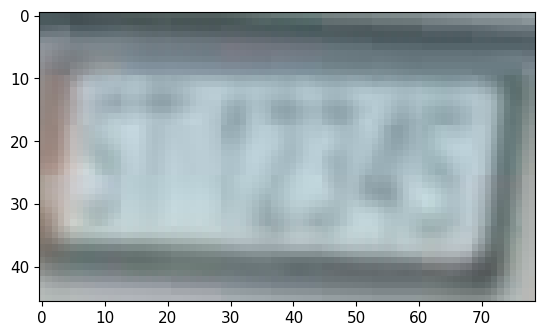

In [ ]:
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]
%matplotlib inline
#boxes = np.matrix(boxes)

fig, axs = plt.subplots(len(boxes))

for i, box in enumerate(boxes):
    box = [int(x) for x in box]
    x1, y1, x2, y2 = box
    print(x1, y1, x2, y2)
    reg = img[y1:y2, x1:x2]
    print(reg.shape)
    axs[i].imshow(reg)

